# Simple state space model for 2pp voting intention

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span><ul class="toc-item"><li><span><a href="#Set-up-Analysis-constants" data-toc-modified-id="Set-up-Analysis-constants-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Set up Analysis constants</a></span></li></ul></li><li><span><a href="#Load-2pp-data-and-prepare-for-analysis" data-toc-modified-id="Load-2pp-data-and-prepare-for-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load 2pp data and prepare for analysis</a></span></li><li><span><a href="#The-model" data-toc-modified-id="The-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The model</a></span><ul class="toc-item"><li><span><a href="#Fit-data-to-model" data-toc-modified-id="Fit-data-to-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Fit data to model</a></span></li><li><span><a href="#Diagnostics" data-toc-modified-id="Diagnostics-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Diagnostics</a></span></li><li><span><a href="#Plot-results" data-toc-modified-id="Plot-results-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Plot results</a></span></li></ul></li><li><span><a href="#Warnings" data-toc-modified-id="Warnings-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Warnings</a></span></li></ul></div>

## Python setup

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import arviz as az
import stan # install with pip - conda is problematic on the M1

# local imports
import common
from common import COLOR_COALITION, P_COLOR_COALITION

In [2]:
# report versions
print(f'numpy: {np.__version__}')
print(f'pandas: {pd.__version__}')
print(f'matplotlib: {mpl.__version__}')
print(f'stan: {stan.__version__}')
print(f'arviz: {az.__version__}')

numpy: 1.21.4
pandas: 1.3.4
matplotlib: 3.5.0
stan: 3.3.0
arviz: 0.11.4


In [3]:
# enable stan on jupyter notebook
import nest_asyncio
nest_asyncio.apply()

In [4]:
# path to the model data - assume it exists
DATA_DIR = '../data/'

In [5]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')

### Set up Analysis constants

In [6]:
# Analysis based on this data ...
data_file = f'{DATA_DIR}primary_vote.csv' # f'{DATA_DIR}two_party_preferred.csv'
POLL_COLUMN = 'Calculated 2pp L/NP' #'2pp vote L/NP'

# Minimum polls requirement for a pollster
MIMIMUM_POLLS_FROM_POLLSTER = 2
# The one ANU poll since 2019 look like a rogue outlier, so let's exclude

# Plot left-side footnotes
s_args = {'lfooter': 'Polling data from Wikipedia; '
          '2pp from primary votes and 2019 preference flows; '
          f'Pollsters ignored with < {MIMIMUM_POLLS_FROM_POLLSTER} polls.'}

## Load 2pp data and prepare for analysis

In [7]:
# Check the data file has been updated today
common.check_file_current(data_file, 
    'Make sure you run the data capture notebook first')

In [8]:
# read in 2pp data; remind me, what are the column names ...
tpp = pd.read_csv(data_file, parse_dates=['Mean Date'], index_col=0)
tpp.columns

Index(['Primary vote L/NP', 'Primary vote ALP', 'Primary vote GRN',
       'Primary vote ONP', 'Primary vote OTH', 'Date', 'Mean Date', 'Brand',
       'Interview mode', 'Sample size', 'Calculated 2pp L/NP',
       'Calculated 2pp ALP'],
      dtype='object')

In [9]:
# Number of polls
len(tpp)

107

In [10]:
# Number of polls from each pollster
brand_counts = tpp['Brand'].value_counts()
brand_counts

Newspoll-YouGov                   40
Essential                         38
Roy Morgan                        20
Resolve Strategic                  8
Australian National University     1
Name: Brand, dtype: int64

In [11]:
# Remove pollsters with minimal polling history
keep = brand_counts[brand_counts >= MIMIMUM_POLLS_FROM_POLLSTER].index
tpp = tpp[tpp['Brand'].isin(keep)]
tpp['Brand'].value_counts()

Newspoll-YouGov      40
Essential            38
Roy Morgan           20
Resolve Strategic     8
Name: Brand, dtype: int64

In [12]:
len(tpp)

106

## The model

### Fit data to model

In [13]:
# this step typically takes around 3 minutes
fit, first_day, brand_map = common.bayes_poll_aggregation(tpp, 
                              poll_column=POLL_COLUMN,
                              date_column='Mean Date',
                              firm_column='Brand',
                              assumed_sample_size=1000,
                              num_chains=4,
                              num_samples=2_500)

Building: found in cache, done.
Messages from stanc:
Sampling:   0%


Stan version: 3.3.0


Sampling:   0% (1/14000)
Sampling:   0% (2/14000)
Sampling:   0% (3/14000)
Sampling:   0% (4/14000)
Sampling:   1% (103/14000)
Sampling:   1% (202/14000)
Sampling:   2% (301/14000)
Sampling:   3% (400/14000)
Sampling:   4% (500/14000)
Sampling:   4% (600/14000)
Sampling:   5% (700/14000)
Sampling:   6% (800/14000)
Sampling:   6% (900/14000)
Sampling:   7% (1000/14000)
Sampling:   8% (1100/14000)
Sampling:   9% (1200/14000)
Sampling:   9% (1300/14000)
Sampling:  10% (1400/14000)
Sampling:  11% (1500/14000)
Sampling:  11% (1600/14000)
Sampling:  12% (1700/14000)
Sampling:  13% (1800/14000)
Sampling:  14% (1900/14000)
Sampling:  14% (2000/14000)
Sampling:  15% (2100/14000)
Sampling:  16% (2200/14000)
Sampling:  16% (2300/14000)
Sampling:  17% (2400/14000)
Sampling:  18% (2500/14000)
Sampling:  19% (2600/14000)
Sampling:  19% (2700/14000)
Sampling:  20% (2800/14000)
Sampling:  21% (2900/14000)
Sampling:  21% (3000/14000)
Sampling:  22% (3100/14000)
Sampling:  23% (3200/14000)
Sampling:  24

### Diagnostics

In [14]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hidden_vote_share[0],52.332,0.985,50.572,54.223,0.012,0.008,7215.0,7522.0,1.0
hidden_vote_share[1],52.323,0.983,50.490,54.164,0.012,0.008,7175.0,7594.0,1.0
hidden_vote_share[2],52.314,0.977,50.496,54.119,0.012,0.008,7139.0,7742.0,1.0
hidden_vote_share[3],52.305,0.974,50.481,54.099,0.012,0.008,7101.0,7643.0,1.0
hidden_vote_share[4],52.299,0.971,50.452,54.074,0.012,0.008,7077.0,7820.0,1.0
...,...,...,...,...,...,...,...,...,...
pHouseEffects[3],-0.237,4.663,-8.919,8.691,0.043,0.061,11573.0,5333.0,1.0
houseEffect[0],-0.480,0.283,-1.009,0.055,0.003,0.002,7489.0,7692.0,1.0
houseEffect[1],-0.681,0.298,-1.230,-0.111,0.004,0.003,6161.0,7137.0,1.0
houseEffect[2],1.374,0.450,0.553,2.245,0.006,0.004,6374.0,7204.0,1.0


In [15]:
# Estimated Bayesian Fraction of Missing Information ...
# Good if close to one; bad if close to zero ...
bfmi = az.bfmi(fit)
if (bfmi <= 0.4).any():
    common.warn(f'Note: the BFMI could be problematic ({bfmi})')

In [16]:
# R-hat chain convergence diagnostic
# ESS - effective sample size (used to be n_eff)
RHAT_THRESHOLD = 1.05
ESS_THRESHOLD = 1000
rhat = az.rhat(fit)
ess = az.ess(fit)
for var in ['houseEffect', 'hidden_vote_share']:
    if (rhat[var] > RHAT_THRESHOLD).any():
        common.warn(f'Check {var} - chain convergence')
    if (ess[var] < ESS_THRESHOLD).any():
        common.warn(f'Check {var} - effective sample size')

array([[<AxesSubplot:title={'center':'houseEffect'}>,
        <AxesSubplot:title={'center':'houseEffect'}>]], dtype=object)

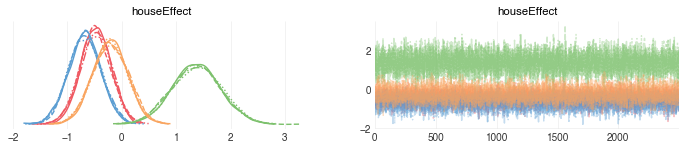

In [17]:
az.plot_trace(fit, var_names=['houseEffect'])

### Plot results

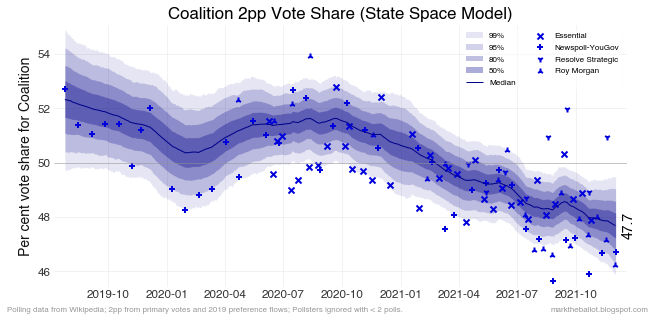

0
Essential           -0.478478
Newspoll-YouGov     -0.678650
Resolve Strategic    1.374757
Roy Morgan          -0.213554
Name: 0.5, dtype: float64


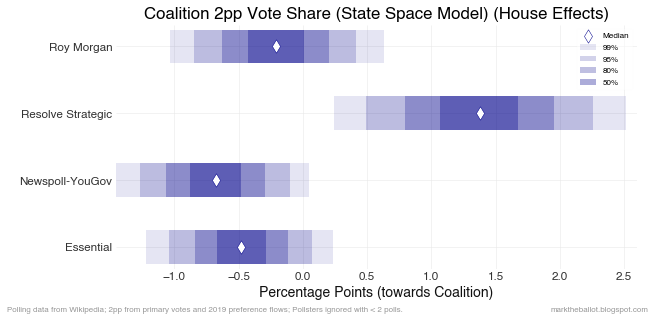

In [18]:
common.bayes_poll_aggregation_plots(df=tpp, 
                             fit=fit, 
                             first_day=first_day, 
                             brand_map=brand_map,
                              poll_column=POLL_COLUMN,
                              date_column='Mean Date',
                              firm_column='Brand',
                                 party='Coalition',
                                 title='2pp Vote Share (State Space Model)',
                                 line_color=COLOR_COALITION,
                                 point_color=P_COLOR_COALITION,
                                 s_args=s_args)


## Warnings

In [19]:
common.print_warnings()